##  Итоговый проект по курсу "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn".
Задание для итогового проекта:

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на ноутбук в github или public kaggle notebook.
2. Необходимо получить R2 > 0.6.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

Для начало определим, что такое коэффициент детерминации $\R^2$ и что для него нужно.

Коэффициент детерминации $\R^2$ — это статистическая мера, используемая для оценки качества регрессионной модели. Он показывает, какую долю дисперсии зависимой переменной можно объяснить с помощью независимых переменных в модели. Значение $\R^2$ варьируется от 0 до 1, где 0 указывает на то, что модель не объясняет вариацию зависимой переменной, а 1 означает идеальное соответствие модели данным.

Составим краткий план действий: После загрузки данных, проверяем данные на наличие пропусков и выполняем необходимую очистку. Определяем признаки и целевую переменную. Построение модели и ее обучение. Оценка и интерпретация результатов. 

## Импорт необходимых библиотек

In [1526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)



## Загрузка данных

In [1527]:
train_data = pd.read_csv('train.csv', encoding='utf-8')
test_data = pd.read_csv('test.csv', encoding='utf-8')

## Предварительный анализ данных

### Размер обучающего и тестовогонабора

In [1528]:
print("Размер обучающего набора:", train_data.shape)
print("Размер тестового набора:", test_data.shape)

Размер обучающего набора: (10000, 20)
Размер тестового набора: (5000, 19)


### Информация о наборах данных

In [1529]:
print("\nИнформация о обучающем наборе:")
train_data.info(memory_usage='deep')


Информация о обучающем наборе:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        1000

In [1530]:
print("\nИнформация о тестовом наборе:")
test_data.info(memory_usage='deep')


Информация о тестовом наборе:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 n

### Проверка на пропуски

In [1531]:
print("\nПропуски в обучающем наборе:")
print(train_data.isnull().sum())


Пропуски в обучающем наборе:
Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64


In [1532]:
print("\nПропуски в тестовом наборе:")
print(test_data.isnull().sum())


Пропуски в тестовом наборе:
Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64


#### Анализ пропущенных значений в обучающем наборе

In [1533]:
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_percentages = 100 * missing_values / len(train_data)

missing_df = pd.concat([missing_values, missing_percentages], axis=1, keys=['Количество', 'Процент'])
print(missing_df[missing_df['Количество'] > 0])

              Количество  Процент
Healthcare_1        4798    47.98
LifeSquare          2113    21.13


### Проверка дубликатов

In [1534]:
print(f"\nКоличество дубликатов в обучающем наборе: {train_data.duplicated().sum()}")
print(f"\nКоличество дубликатов в тестовом наборе: {test_data.duplicated().sum()}")


Количество дубликатов в обучающем наборе: 0

Количество дубликатов в тестовом наборе: 0


### Обзор базовой статистики

In [1535]:
print("\nСтатистика обучающего набора:")
train_data.describe()


Статистика обучающего набора:


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00,10000.00,10000.00,10000.00,7887.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,5202.00,10000.00,10000.00,10000.00
mean,8383.41,50.40,1.89,56.32,37.20,6.27,8.53,12.61,3990.17,0.12,24.69,5352.16,8.04,1142.90,1.32,4.23,214138.86
std,4859.02,43.59,0.84,21.06,86.24,28.56,5.24,6.78,200500.26,0.12,17.53,4006.80,23.83,1021.52,1.49,4.81,92872.29
min,0.00,0.00,0.00,1.14,0.37,0.00,1.00,0.00,1910.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,59174.78
25%,4169.50,20.00,1.00,41.77,22.77,1.00,4.00,9.00,1974.00,0.02,6.00,1564.00,0.00,350.00,0.00,1.00,153872.63
50%,8394.50,36.00,2.00,52.51,32.78,6.00,7.00,13.00,1977.00,0.08,25.00,5285.00,2.00,900.00,1.00,3.00,192269.64
75%,12592.50,75.00,2.00,65.90,45.13,9.00,12.00,17.00,2001.00,0.20,36.00,7227.00,5.00,1548.00,2.00,6.00,249135.46
max,16798.00,209.00,19.00,641.07,7480.59,2014.00,42.00,117.00,20052011.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00,633233.47


In [1536]:
print("\nСтатистика тестового набора:")
test_data.describe()


Статистика тестового набора:


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00,5000.00,5000.00,5000.00,3959.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,2623.00,5000.00,5000.00
mean,8412.60,51.28,1.91,56.45,36.16,5.98,8.63,12.60,1984.39,0.12,24.93,5406.90,8.26,1146.66,1.32,4.24
std,4832.67,44.18,0.84,19.09,17.83,9.95,5.48,6.79,18.57,0.12,17.53,4026.61,23.86,1044.74,1.48,4.78
min,1.00,0.00,0.00,1.38,0.33,0.00,1.00,0.00,1908.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00
25%,4221.75,21.00,1.00,41.91,23.09,1.00,4.00,9.00,1973.00,0.02,6.00,1564.00,0.00,325.00,0.00,1.00
50%,8320.50,37.00,2.00,52.92,32.93,6.00,7.00,12.00,1977.00,0.07,25.00,5285.00,2.00,900.00,1.00,3.00
75%,12598.25,77.00,2.00,66.29,45.17,9.00,12.00,17.00,2000.00,0.20,36.00,7287.00,5.00,1548.00,2.00,6.00
max,16795.00,212.00,17.00,223.45,303.07,620.00,78.00,99.00,2020.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00


### Анализ распределения целевой переменной

In [1537]:
print(train_data['Price'].describe())

count    10000.00
mean    214138.86
std      92872.29
min      59174.78
25%     153872.63
50%     192269.64
75%     249135.46
max     633233.47
Name: Price, dtype: float64


### Корреляционный анализ

In [1538]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = train_data[numeric_columns].corr()
correlation_matrix

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Id,1.00,0.01,-0.01,-0.01,0.02,0.02,0.00,-0.01,0.01,0.02,-0.00,-0.00,-0.01,-0.00,0.00,-0.01,0.01
DistrictId,0.01,1.00,0.07,-0.03,-0.02,0.04,-0.12,-0.15,0.01,0.07,0.25,0.17,0.14,0.30,0.31,0.17,0.27
Rooms,-0.01,0.07,1.00,0.66,0.13,0.01,-0.00,-0.03,-0.01,-0.03,0.08,0.07,0.01,0.04,0.06,0.05,0.55
Square,-0.01,-0.03,0.66,1.00,0.20,0.01,0.11,0.08,-0.01,-0.06,-0.07,-0.04,0.04,-0.04,-0.02,0.02,0.52
LifeSquare,0.02,-0.02,0.13,0.20,1.00,-0.00,0.02,0.03,-0.00,-0.02,-0.05,-0.04,0.01,-0.03,-0.02,-0.01,0.08
KitchenSquare,0.02,0.04,0.01,0.01,-0.00,1.00,-0.01,0.00,0.00,-0.01,0.04,0.04,-0.02,0.01,0.04,0.01,0.03
Floor,0.00,-0.12,-0.00,0.11,0.02,-0.01,1.00,0.42,0.00,-0.02,-0.04,-0.02,-0.00,-0.14,-0.07,0.02,0.13
HouseFloor,-0.01,-0.15,-0.03,0.08,0.03,0.00,0.42,1.00,-0.00,-0.00,-0.02,0.01,-0.01,-0.14,-0.07,0.03,0.09
HouseYear,0.01,0.01,-0.01,-0.01,-0.00,0.00,0.00,-0.00,1.00,0.00,0.00,0.00,0.00,-0.01,0.01,0.00,0.00
Ecology_1,0.02,0.07,-0.03,-0.06,-0.02,-0.01,-0.02,-0.00,0.00,1.00,0.03,0.01,-0.12,-0.04,0.03,-0.08,-0.06


### Анализ категориальных переменных

In [1539]:
categorical_columns = train_data.select_dtypes(include=['object']).columns
categorical_columns

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

### Исследовательский анализ данных (EDA)

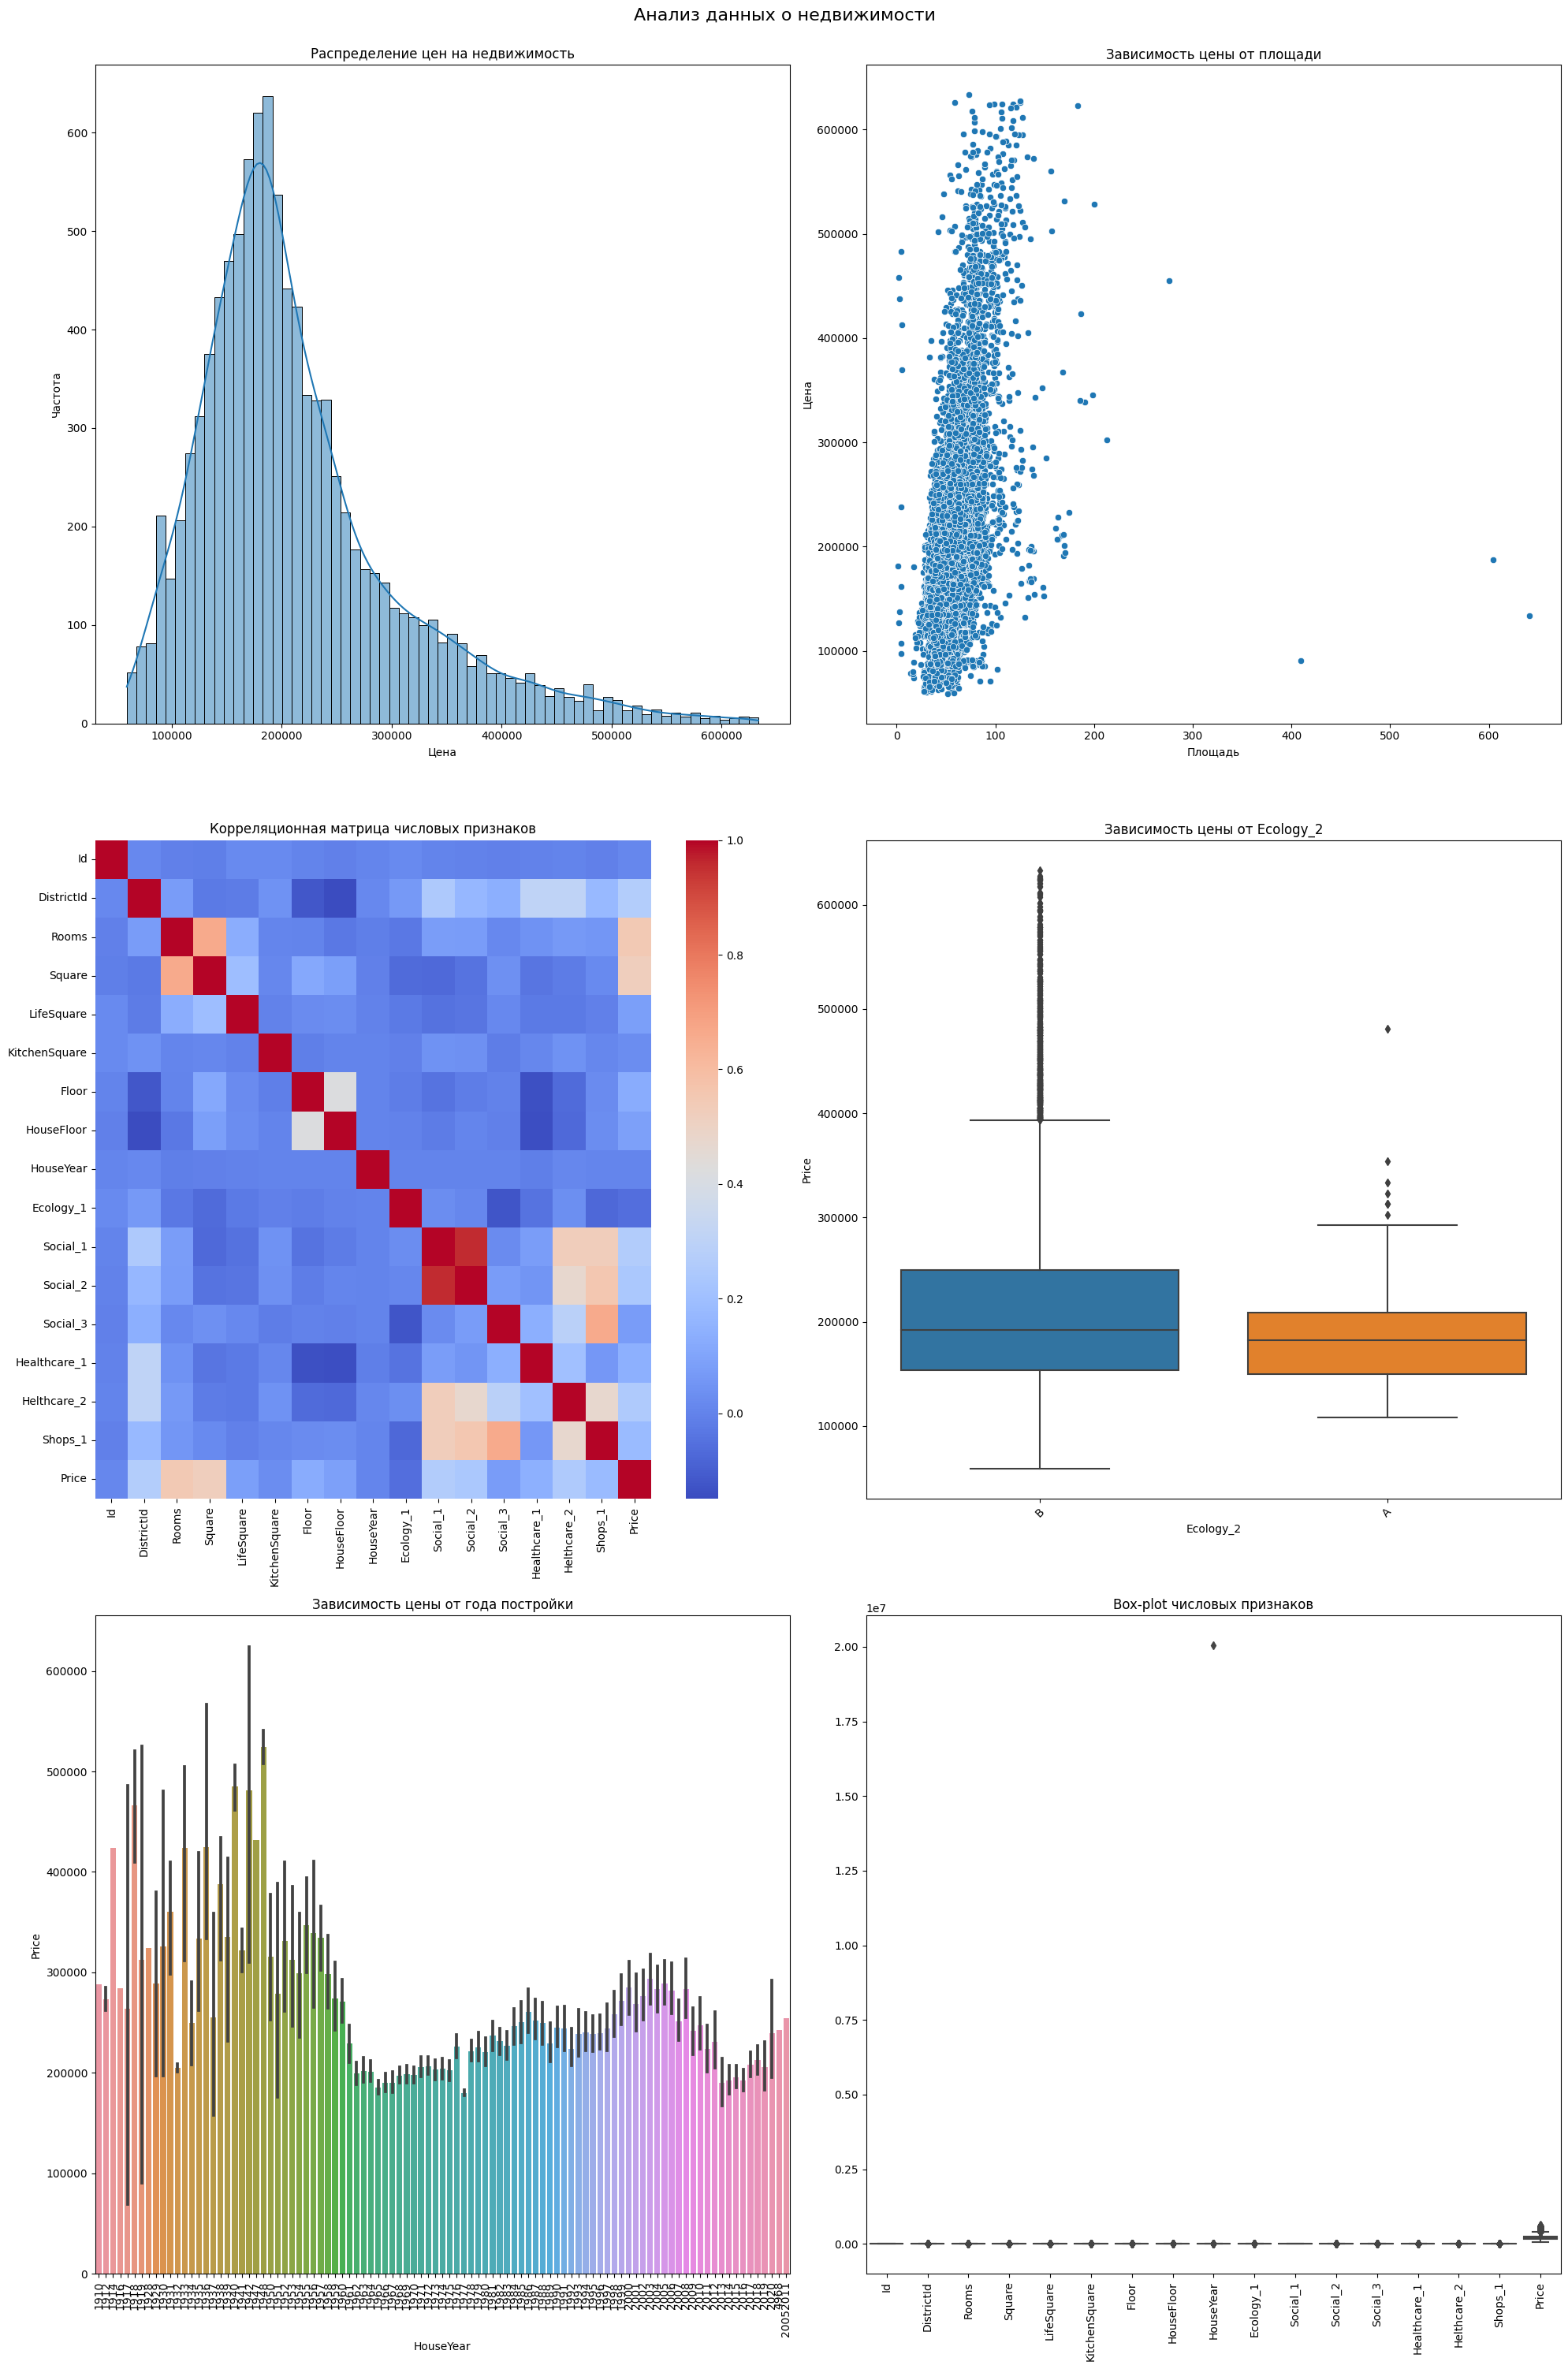

In [1540]:
# Создаем одно большое полотно
fig = plt.figure(figsize=(20, 30))

# 1. Распределение цен на недвижимость
ax1 = fig.add_subplot(3, 2, 1)
sns.histplot(train_data['Price'], kde=True, ax=ax1)
ax1.set_title('Распределение цен на недвижимость')
ax1.set_xlabel('Цена')
ax1.set_ylabel('Частота')

# 2. Зависимость цены от площади
ax2 = fig.add_subplot(3, 2, 2)
sns.scatterplot(x='Square', y='Price', data=train_data, ax=ax2)
ax2.set_title('Зависимость цены от площади')
ax2.set_xlabel('Площадь')
ax2.set_ylabel('Цена')

# 3. Корреляционная матрица числовых признаков
ax3 = fig.add_subplot(3, 2, 3)
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', ax=ax3)
ax3.set_title('Корреляционная матрица числовых признаков')

# 4. Анализ категориальных переменных
ax4 = fig.add_subplot(3, 2, 4)
sns.boxplot(x=categorical_columns[0], y='Price', data=train_data, ax=ax4)
ax4.set_title(f'Зависимость цены от {categorical_columns[0]}')
ax4.tick_params(axis='x', rotation=45)

# 5. Временной анализ
ax5 = fig.add_subplot(3, 2, 5)
sns.barplot(x='HouseYear', y='Price', data=train_data, ax=ax5)
ax5.set_title('Зависимость цены от года постройки')
ax5.tick_params(axis='x', rotation=90)

# 6. Анализ выбросов
ax6 = fig.add_subplot(3, 2, 6)
sns.boxplot(data=train_data[numeric_columns], ax=ax6)
ax6.set_title('Box-plot числовых признаков')
ax6.tick_params(axis='x', rotation=90)

# Настройка общего заголовка и расстояния между графиками
plt.suptitle('Анализ данных о недвижимости', y=1, fontsize=16)
plt.tight_layout()
plt.show()

## Предобработка данных

In [1541]:
train_data['Rooms'] = train_data['Rooms'].astype('int64')
test_data['Rooms'] = test_data['Rooms'].astype('int64')

In [1542]:
train_data['HouseFloor'] = train_data['HouseFloor'].astype('int64')
test_data['HouseFloor'] = test_data['HouseFloor'].astype('int64')

### Нормализация и кодирование категориальных переменных

In [1543]:
for col in categorical_columns:
    train_data[col] = train_data[col].str.upper()

Применение get_dummies() ко всем категориальным столбцам (categorical_columns) преобразует их в формат, подходящий для большинства алгоритмов машинного обучения.

In [1544]:
train_data = pd.get_dummies(train_data, columns=categorical_columns)

###  Визуализация категориальных переменных после нормализации и кодировании

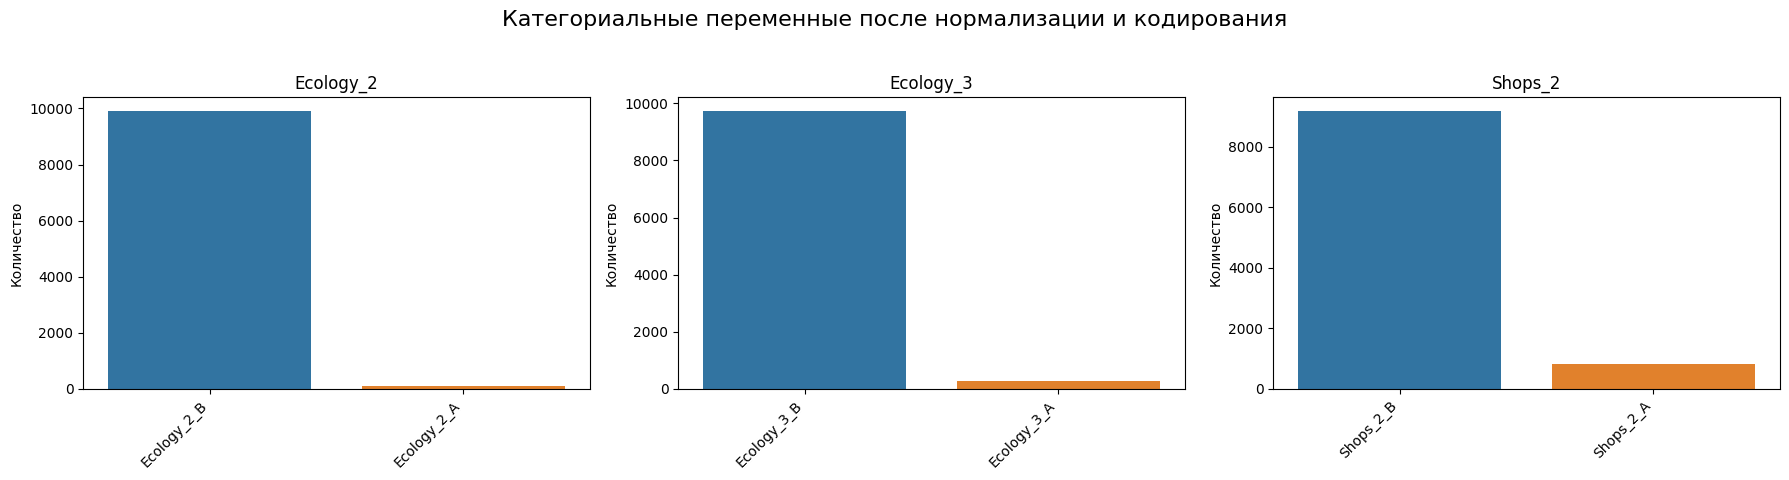

In [1545]:
def plot_categorical_encoded(data, original_columns):
    n_cols = len(original_columns)
    fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 5))
    
    if n_cols == 1:
        axes = [axes]
    
    for idx, col in enumerate(original_columns):
        encoded_cols = [c for c in data.columns if c.startswith(col + '_')]
        encoded_data = data[encoded_cols].sum().sort_values(ascending=False)
        
        sns.barplot(x=encoded_data.index, y=encoded_data.values, ax=axes[idx])
        axes[idx].set_title(col)
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
        axes[idx].set_ylabel('Количество')
    
    # Добавляем общий заголовок
    fig.suptitle('Категориальные переменные после нормализации и кодирования', fontsize=16)
    
    # Увеличиваем расстояние между графиком и общим заголовком
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

# Применяем функцию к нашим данным
categorical_columns = ['Ecology_2', 'Ecology_3', 'Shops_2']
plot_categorical_encoded(train_data, categorical_columns)

## Подготовка признаков

### Проверка на пустые наборы данных

In [1546]:
if train_data.empty:
    print("Ошибка: Обучающий набор данных пуст после предобработки.")
    exit()

if test_data.empty:
    print("Предупреждение: Тестовый набор данных пуст после предобработки.")
    # Создаем фиктивный тестовый набор данных для демонстрации
    test_data = train_data.head(1).copy()
    test_data['Price'] = np.nan

### Проверка на выбросы

Проведем проверку на выбросы для всех числовых признаков, методом межквартильного размаха (IQR).

In [1547]:
def check_outliers(data):
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    outliers_summary = {}

    for column in numeric_columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outliers_count = len(outliers)
        
        if outliers_count > 0:
            outliers_summary[column] = {
                'count': outliers_count,
                'percentage': (outliers_count / len(data)) * 100,
                'min': data[column].min(),
                'max': data[column].max(),
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
    
    return outliers_summary

# Применяем функцию к нашим данным
outliers_result = check_outliers(train_data)

# Выводим результаты
print("Сводка по выбросам:")
for column, info in outliers_result.items():
    print(f"\n{column}:")
    print(f"  Количество выбросов: {info['count']}")
    print(f"  Процент выбросов: {info['percentage']:.2f}%")
    print(f"  Минимальное значение: {info['min']}")
    print(f"  Максимальное значение: {info['max']}")
    print(f"  Нижняя граница: {info['lower_bound']}")
    print(f"  Верхняя граница: {info['upper_bound']}")

Сводка по выбросам:

DistrictId:
  Количество выбросов: 280
  Процент выбросов: 2.80%
  Минимальное значение: 0
  Максимальное значение: 209
  Нижняя граница: -62.5
  Верхняя граница: 157.5

Rooms:
  Количество выбросов: 172
  Процент выбросов: 1.72%
  Минимальное значение: 0
  Максимальное значение: 19
  Нижняя граница: -0.5
  Верхняя граница: 3.5

Square:
  Количество выбросов: 242
  Процент выбросов: 2.42%
  Минимальное значение: 1.1368587776514651
  Максимальное значение: 641.0651927456408
  Нижняя граница: 5.586264180189367
  Верхняя граница: 102.08924188493728

LifeSquare:
  Количество выбросов: 240
  Процент выбросов: 2.40%
  Минимальное значение: 0.3706194194766937
  Максимальное значение: 7480.592128925202
  Нижняя граница: -10.76862370672341
  Верхняя граница: 78.66725866176199

KitchenSquare:
  Количество выбросов: 47
  Процент выбросов: 0.47%
  Минимальное значение: 0.0
  Максимальное значение: 2014.0
  Нижняя граница: -11.0
  Верхняя граница: 21.0

Floor:
  Количество выбр

### Признак Rooms

Так как 1.72% выбросов, то можно ограничить верхнюю границу. Квартиры с более чем 7-8 комнатами встречаются редко

In [1548]:
train_data['Rooms'] = train_data['Rooms'].clip(upper=8)

Подсчет количества записей, где Rooms <= 0

In [1549]:
invalid_rooms = train_data[train_data['Rooms'] <= 0]
invalid_rooms_count = len(invalid_rooms)

print(f"Количество записей, где Rooms <= 0: {invalid_rooms_count}")

if invalid_rooms_count > 0:
    print("\nРаспределение недопустимых значений:")
    print(invalid_rooms['Rooms'].value_counts().sort_index())
    
    print("\nВсе записи с недопустимыми значениями:")
    print(invalid_rooms[['Id', 'Rooms', 'Square', 'Price']])
else:
    print("Все значения признака 'Rooms' положительные и больше нуля.")

Количество записей, где Rooms <= 0: 8

Распределение недопустимых значений:
0    8
Name: Rooms, dtype: int64

Все записи с недопустимыми значениями:
         Id  Rooms  Square     Price
1397  12638      0  138.43 268394.74
1981   7917      0  212.93 302211.26
2269   7317      0   41.79  98129.98
3911    770      0   49.48 217009.34
4366    456      0   81.49 212864.80
4853   3224      0    2.38 126596.94
6149   3159      0   38.70 158998.11
8834   9443      0   87.76 219281.92


Заменим недопустимуе значения на медиану

In [1550]:
# Сначала посчитаем медиану, исключая недопустимые значения
median_rooms = train_data[train_data['Rooms'] > 0]['Rooms'].median()

print(f"Медианное значение количества комнат (исключая недопустимые): {median_rooms}")

# Сохраним количество недопустимых значений до замены
invalid_rooms_count_before = len(train_data[train_data['Rooms'] <= 0])

# Заменяем недопустимые значения на медиану
train_data.loc[train_data['Rooms'] <= 0, 'Rooms'] = median_rooms

# Проверяем, сколько значений было заменено
invalid_rooms_count_after = len(train_data[train_data['Rooms'] <= 0])

print(f"\nКоличество замененных значений: {invalid_rooms_count_before}")
print(f"Количество оставшихся недопустимых значений: {invalid_rooms_count_after}")

# Выводим обновленную статистику по столбцу 'Rooms'
print("\nОбновленная статистика по столбцу 'Rooms':")
print(train_data['Rooms'].describe())

# Проверяем минимальное значение после замены
min_rooms = train_data['Rooms'].min()
print(f"\nМинимальное значение 'Rooms' после замены: {min_rooms}")

Медианное значение количества комнат (исключая недопустимые): 2.0

Количество замененных значений: 8
Количество оставшихся недопустимых значений: 0

Обновленная статистика по столбцу 'Rooms':
count   10000.00
mean        1.89
std         0.82
min         1.00
25%         1.00
50%         2.00
75%         2.00
max         8.00
Name: Rooms, dtype: float64

Минимальное значение 'Rooms' после замены: 1


### Признак Square, LifeSquare, KitchenSquare

Количество пропусков LifeSquare 21.13 %, заменим на медиану

In [1551]:
# Вычислим медиану LifeSquare, игнорируя пропущенные значения
median_lifesquare = train_data['LifeSquare'].median()
print(f"Медианное значение LifeSquare: {median_lifesquare}")

# Заменим пропуски на медиану
train_data['LifeSquare'].fillna(median_lifesquare, inplace=True)

# Проверим, остались ли пропущенные значения
remaining_missing = train_data['LifeSquare'].isnull().sum()
print(f"Оставшиеся пропущенные значения в LifeSquare: {remaining_missing}")

# Выведем обновленную статистику по столбцу LifeSquare
print("\nОбновленная статистика LifeSquare:")
print(train_data['LifeSquare'].describe())

# Создадим флаг для отметки заполненных значений
train_data['LifeSquare_Imputed'] = train_data['LifeSquare'].isnull().astype(int)

# Выведем количество заполненных значений
print(f"\nКоличество заполненных значений: {train_data['LifeSquare_Imputed'].sum()}")

Медианное значение LifeSquare: 32.78126019215574
Оставшиеся пропущенные значения в LifeSquare: 0

Обновленная статистика LifeSquare:
count   10000.00
mean       36.27
std        76.61
min         0.37
25%        25.53
50%        32.78
75%        41.43
max      7480.59
Name: LifeSquare, dtype: float64

Количество заполненных значений: 0


Проверка, что LifeSquare больше максимальной Square

In [1552]:
train_data[train_data['LifeSquare'] > train_data['Square'].max()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,LifeSquare_Imputed
4328,16550,27,3,81.69,7480.59,1.00,9,17,2016,0.02,...,0,0,217357.49,0,1,0,1,0,1,0


In [1553]:
# Округляем метраж до целых чисел
train_data['Square'] = train_data['Square'].apply(lambda x: round(x, 0))
train_data['LifeSquare'] = train_data['LifeSquare'].apply(lambda x: round(x, 0))

# Заменим несоответствие LifeSquare
train_data.loc[(train_data['LifeSquare'] > train_data['Square'].max()), ['LifeSquare']] = train_data['Square']

Проверка, что LifeSquare не больше Square

In [1554]:
train_data[train_data['LifeSquare'] > train_data['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,LifeSquare_Imputed
28,8054,23,1,43.00,44.00,1.00,3,9,2014,0.03,...,0,0,95338.20,0,1,0,1,0,1,0
44,10521,38,3,104.00,106.00,0.00,20,0,2017,0.06,...,0,7,435462.05,0,1,0,1,0,1,0
52,2301,1,2,61.00,65.00,0.00,17,22,2016,0.01,...,0,1,199215.45,0,1,0,1,0,1,0
123,8753,25,3,86.00,90.00,1.00,4,3,2017,0.07,...,1,11,309688.59,0,1,0,1,0,1,0
153,9870,62,1,52.00,53.00,1.00,5,1,2015,0.07,...,0,0,131797.47,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9864,8807,38,1,47.00,50.00,10.00,8,17,2019,0.06,...,0,7,256650.66,0,1,0,1,0,1,0
9889,12918,23,2,51.00,53.00,51.00,3,17,2017,0.01,...,0,0,88150.01,0,1,0,1,0,1,0
9895,2737,27,3,123.00,126.00,123.00,5,10,2015,0.02,...,0,0,234194.84,0,1,0,1,0,1,0
9910,16568,27,4,200.00,202.00,25.00,1,2,2013,0.04,...,1,4,528560.51,0,1,0,1,0,1,0


Проверка, что KitchenSquare не больше Square

In [1555]:
train_data[train_data['KitchenSquare'] > train_data['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,LifeSquare_Imputed
1064,14656,62,1,47.00,46.00,2014.00,4,1,2014,0.07,...,0,0,108337.48,0,1,0,1,1,0,0
5149,13703,42,1,38.00,20.00,73.00,9,10,2006,0.16,...,1,0,160488.03,0,1,0,1,0,1,0
7088,6569,27,1,38.00,19.00,84.00,4,17,2018,0.01,...,0,0,99079.96,0,1,0,1,0,1,0
8584,14679,81,1,32.00,19.00,1970.00,6,1,1977,0.01,...,6,6,105539.56,0,1,0,1,0,1,0


Зяменяем несоответствие на медиану

In [1556]:
median_kitchen = train_data['KitchenSquare'].median()

def correct_kitchen_square(row):
    if row['KitchenSquare'] > row['Square']:
        if row['Square'] - row['LifeSquare'] < median_kitchen:
            return row['Square'] - row['LifeSquare']
        else:
            return median_kitchen
    return row['KitchenSquare']

train_data['KitchenSquare'] = train_data.apply(correct_kitchen_square, axis=1)

Так как в США другие нормы. И кухня не входит в жилую площадь, то эту позицию не проверяем

### Признак Floor, HouseFloor

Проверка, что Floor не больше HouseFloor

In [1557]:
# Проверяем количество записей, где Floor > HouseFloor или HouseFloor было 0
total_corrected = len(train_data[(train_data['Floor'] > train_data['HouseFloor']) | (train_data['HouseFloor'] == 0)])
print(f"Общее количество записей: {total_corrected}")

Общее количество записей: 1825


Заменим значение HouseFloor на Floor в случаях, когда Floor больше HouseFloor или когда HouseFloor равно 0. 

In [1558]:
# Сохраняем исходные значения
train_data['Original_HouseFloor'] = train_data['HouseFloor']

# Функция для корректировки значений
def correct_house_floor(row):
    if row['Floor'] > row['HouseFloor'] or row['HouseFloor'] == 0:
        return row['Floor']
    return row['HouseFloor']

# Подсчитываем количество записей до коррекции
total_before = len(train_data[(train_data['Floor'] > train_data['HouseFloor']) | (train_data['HouseFloor'] == 0)])
print(f"Количество записей для коррекции: {total_before}")

# Применяем функцию к датафрейму
train_data['HouseFloor'] = train_data.apply(correct_house_floor, axis=1)

# Создаем флаг для отметки исправленных записей
train_data['HouseFloor_Corrected'] = (train_data['HouseFloor'] != train_data['Original_HouseFloor']).astype(int)

# Подсчитываем количество исправленных записей
corrected_count = train_data['HouseFloor_Corrected'].sum()
print(f"Количество исправленных записей: {corrected_count}")

# Проверяем, остались ли несоответствия после коррекции
remaining_inconsistencies = len(train_data[(train_data['Floor'] > train_data['HouseFloor']) | (train_data['HouseFloor'] == 0)])
print(f"Оставшиеся несоответствия после коррекции: {remaining_inconsistencies}")

# Выводим статистику HouseFloor до и после коррекции
print("\nСтатистика HouseFloor до коррекции:")
print(train_data['Original_HouseFloor'].describe())

print("\nСтатистика HouseFloor после коррекции:")
print(train_data['HouseFloor'].describe())

Количество записей для коррекции: 1825
Количество исправленных записей: 1825
Оставшиеся несоответствия после коррекции: 0

Статистика HouseFloor до коррекции:
count   10000.00
mean       12.61
std         6.78
min         0.00
25%         9.00
50%        13.00
75%        17.00
max       117.00
Name: Original_HouseFloor, dtype: float64

Статистика HouseFloor после коррекции:
count   10000.00
mean       13.44
std         6.09
min         1.00
25%         9.00
50%        14.00
75%        17.00
max       117.00
Name: HouseFloor, dtype: float64


### Признак HouseYear

In [1559]:
anomalous_houses = train_data[(train_data['HouseYear'] < 1800) | (train_data['HouseYear'] > 2024)]
print(f"Количество аномальных записей: {len(anomalous_houses)}")
anomalous_houses

Количество аномальных записей: 2


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,LifeSquare_Imputed,Original_HouseFloor,HouseFloor_Corrected
1497,10814,109,1,37.00,20.00,9.00,9,12.00,20052011,0.14,...,254084.53,0,1,0,1,0,1,0,12,0
4189,11607,147,2,45.00,28.00,5.00,4,9.00,4968,0.32,...,243028.60,0,1,0,1,0,1,0,9,0


Ограничим диапазон значениями (1800-2024)

In [1560]:
train_data['HouseYear'] = train_data['HouseYear'].clip(1800, 2024)

Создание нового признака 'Возраст дома'

In [1561]:
# Возраст дома
train_data['HouseAge'] = 2024 - train_data['HouseYear']

In [1562]:
print(f"Самый старый дом: {test_data['HouseYear'].min()} год")
print(f"Самый новый дом: {test_data['HouseYear'].max()} год")

Самый старый дом: 1908 год
Самый новый дом: 2020 год


### Признак 'Healthcare_1'

В признаке Healthcare_1'   47.98 % пропусков, поэтому его удаляю.

In [1563]:
train_data.drop('Healthcare_1', axis=1, inplace=True)

### Создание нового признаков

In [1564]:
# Отношение жилой площади к общей
train_data['LifeSquareRatio'] = train_data['LifeSquare'] / train_data['Square']

# Отношение площади кухни к общей площади
train_data['KitchenSquareRatio'] = train_data['KitchenSquare'] / train_data['Square']

# Этаж относительно этажности дома
train_data['RelativeFloor'] = train_data['Floor'] / train_data['HouseFloor']

print("Созданы новые признаки")

Созданы новые признаки


### Создание модели

Подготовка данных для моделирования

In [1565]:
features = [col for col in train_data.columns if col not in ['Id', 'Price']]
X = train_data[features]
# Выделение целевой переменной:
y = train_data['Price'] 

Разделение данных на обучающую и валидационную выборки

In [1566]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Масштабирование признаков. Сначала scaler обучается на обучающей выборке, затем применяется к обеим выборкам.

In [1567]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Выбор и обучение модели

In [1568]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

Оценка модели на валидационной выборке

In [1569]:
y_pred_val = model.predict(X_val_scaled)
r2_val = r2_score(y_val, y_pred_val)
print(f"R2 на валидационной выборке: {r2_val:.4f}")

R2 на валидационной выборке: 0.7419


### Предсказание на тестовых данных и сохранение результатов

Применим те же преобразования к test_data, что и к train_data


In [1570]:
test_data['Rooms'] = test_data['Rooms'].astype('int64')

test_data['HouseFloor'] = test_data['HouseFloor'].astype('int64')

"""### Нормализация и кодирование категориальных переменных"""

for col in categorical_columns:
    test_data[col] = test_data[col].str.upper()

"""Применение get_dummies() ко всем категориальным столбцам (categorical_columns) преобразует их в формат, подходящий для большинства алгоритмов машинного обучения."""

test_data = pd.get_dummies(test_data, columns=categorical_columns)

test_data['Rooms'] = test_data['Rooms'].clip(upper=8)

"""Подсчет количества записей, где Rooms <= 0"""

invalid_rooms = test_data[test_data['Rooms'] <= 0]
invalid_rooms_count = len(invalid_rooms)

"""Заменим недопустимуе значения на медиану"""

# Сначала посчитаем медиану, исключая недопустимые значения
median_rooms = test_data[test_data['Rooms'] > 0]['Rooms'].median()

# Сохраним количество недопустимых значений до замены
invalid_rooms_count_before = len(test_data[test_data['Rooms'] <= 0])

# Заменяем недопустимые значения на медиану
test_data.loc[test_data['Rooms'] <= 0, 'Rooms'] = median_rooms

"""### Признак Square, LifeSquare, KitchenSquare
"""

# Вычислим медиану LifeSquare, игнорируя пропущенные значения
median_lifesquare = test_data['LifeSquare'].median()

# Заменим пропуски на медиану
test_data['LifeSquare'].fillna(median_lifesquare, inplace=True)
# Создадим флаг для отметки заполненных значений
test_data['LifeSquare_Imputed'] = test_data['LifeSquare'].isnull().astype(int)

"""Проверка, что LifeSquare больше максимальной Square"""

test_data[test_data['LifeSquare'] > test_data['Square'].max()]

# Округляем метраж до целых чисел
test_data['Square'] = test_data['Square'].apply(lambda x: round(x, 0))
test_data['LifeSquare'] = test_data['LifeSquare'].apply(lambda x: round(x, 0))

# Заменим несоответствие LifeSquare
test_data.loc[(test_data['LifeSquare'] > test_data['Square'].max()), ['LifeSquare']] = test_data['Square']

"""Проверка, что LifeSquare не больше Square"""

test_data[test_data['LifeSquare'] > test_data['Square']]

"""Проверка, что KitchenSquare не больше Square"""

test_data[test_data['KitchenSquare'] > test_data['Square']]

"""Зяменяем несоответствие на медиану"""

median_kitchen = test_data['KitchenSquare'].median()

def correct_kitchen_square(row):
    if row['KitchenSquare'] > row['Square']:
        if row['Square'] - row['LifeSquare'] < median_kitchen:
            return row['Square'] - row['LifeSquare']
        else:
            return median_kitchen
    return row['KitchenSquare']

test_data['KitchenSquare'] = test_data.apply(correct_kitchen_square, axis=1)

"""
### Признак Floor, HouseFloor

Проверка, что Floor не больше HouseFloor
"""
# Проверяем количество записей, где Floor > HouseFloor или HouseFloor было 0
total_corrected = len(test_data[(test_data['Floor'] > test_data['HouseFloor']) | (test_data['HouseFloor'] == 0)])

"""Заменим значение HouseFloor на Floor в случаях, когда Floor больше HouseFloor или когда HouseFloor равно 0."""

# Сохраняем исходные значения
test_data['Original_HouseFloor'] = test_data['HouseFloor']

# Функция для корректировки значений
def correct_house_floor(row):
    if row['Floor'] > row['HouseFloor'] or row['HouseFloor'] == 0:
        return row['Floor']
    return row['HouseFloor']

# Применяем функцию к датафрейму
test_data['HouseFloor'] = test_data.apply(correct_house_floor, axis=1)

# Создаем флаг для отметки исправленных записей
test_data['HouseFloor_Corrected'] = (test_data['HouseFloor'] != test_data['Original_HouseFloor']).astype(int)

"""Создание нового признака 'Возраст дома'"""

# Возраст дома
test_data['HouseAge'] = 2024 - test_data['HouseYear']

"""### Признак 'Healthcare_1'
"""

test_data.drop('Healthcare_1', axis=1, inplace=True)

"""### Создание нового признаков"""

# Отношение жилой площади к общей
test_data['LifeSquareRatio'] = test_data['LifeSquare'] / test_data['Square']

# Отношение площади кухни к общей площади
test_data['KitchenSquareRatio'] = test_data['KitchenSquare'] / test_data['Square']

# Этаж относительно этажности дома
test_data['RelativeFloor'] = test_data['Floor'] / test_data['HouseFloor']

In [1571]:
X_test = test_data[features]
X_test_scaled = scaler.transform(X_test)
y_pred_test = model.predict(X_test_scaled)

submission = pd.DataFrame({'Id': test_data['Id'], 'Price': y_pred_test})
submission.to_csv('submission.csv', index=False)
print("Предсказания сохранены в файл 'submission.csv'")

Предсказания сохранены в файл 'submission.csv'


### Анализ важности признаков

In [1572]:
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)
print("\nТоп-10 важных признаков:")
print(feature_importance)


Топ-10 важных признаков:
       feature  importance
2       Square        0.42
10    Social_2        0.10
9     Social_1        0.09
11    Social_3        0.09
1        Rooms        0.07
0   DistrictId        0.06
8    Ecology_1        0.05
23    HouseAge        0.02
6   HouseFloor        0.02
13     Shops_1        0.01


### Визуализация важности признаков

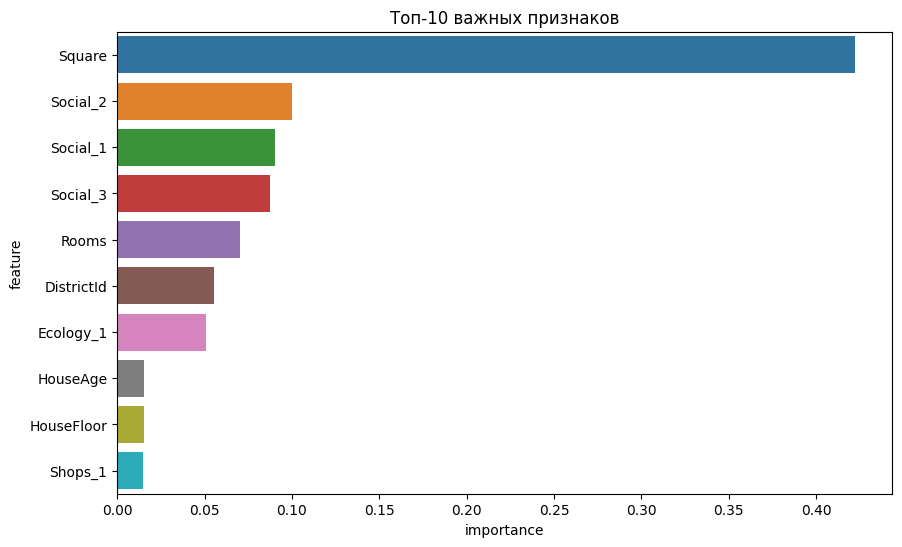

In [1573]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Топ-10 важных признаков')
plt.show()

R2 на валидационной выборке: 0.7419. Что удовлетворяет требованию.

## Используемая литература
1. Коэффициент детерминации Основы эконометрики - https://www.youtube.com/watch?v=W7fdMV7o3T8&pp=ygVW0LrQvtGN0YTRhNC40YbQuNC10L3RgiDQtNC10YLQtdGA0LzQuNC90LDQt9C40Lgg0LIg0LzQsNGI0LjQvdC90L7QvtC8INC-0LHRg9GH0LXQvdC40Lg%3D
6